In [1]:
import os
import glob
import numpy as np
from numpy import ones
import pandas as pd
#import geopandas as gpd
import xarray as xr
import dask
import datetime
import math
import pathlib
import hashlib
import yaml
import re
import pdb
import logging
from tqdm import tqdm


dask.config.set({'array.slicing.split_large_chunks': False})

# To make this notebook's output stable across runs
np.random.seed(42)

# Config matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


# Custom utils
from utils.utils_data import *
from utils.utils_ml import *
from utils.utils_resnet import *
from utils.utils_plot import *
from utils.utils_unet import *


In [2]:
import yaml
conf = yaml.safe_load(open("config.yaml"))

In [3]:
# Load data
lons_x = np.load('tmp/data/lons_y.npy')
lats_y = np.load('tmp/data/lats_y.npy')
# load predictors
dg_train_X = np.array(xr.open_dataarray('tmp/data/dg_train_X.nc'))
dg_test_X = np.array(xr.open_dataarray('tmp/data/dg_test_X.nc'))
# load amount of precipitation
dg_train_Y = np.array(xr.open_dataarray('tmp/data/dg_train_Y.nc')).squeeze()
dg_test_Y = np.array(xr.open_dataarray('tmp/data/dg_test_Y.nc')).squeeze()
# load extremes
dg_train_Y_xtrm = np.array(xr.open_dataarray('tmp/data/dg_train_Y_xtrm0.95th.nc')).squeeze()
dg_test_Y_xtrm = np.array(xr.open_dataarray('tmp/data/dg_test_Y_xtrm0.95th.nc')).squeeze()
# load percentiles
qq = np.load('tmp/data/qq_095.npy')

In [4]:
times = np.arange(np.datetime64('2016-01-01'), np.datetime64('2022-01-01'))
times = pd.to_datetime(times)

In [41]:
# Still need to add RF
models_report = ['Dav-orig', 'Dav-64', 'Pan-orig','CNN-2l','UNET']

Dav-orig
Dav-64
Pan-orig
CNN-2l
UNET


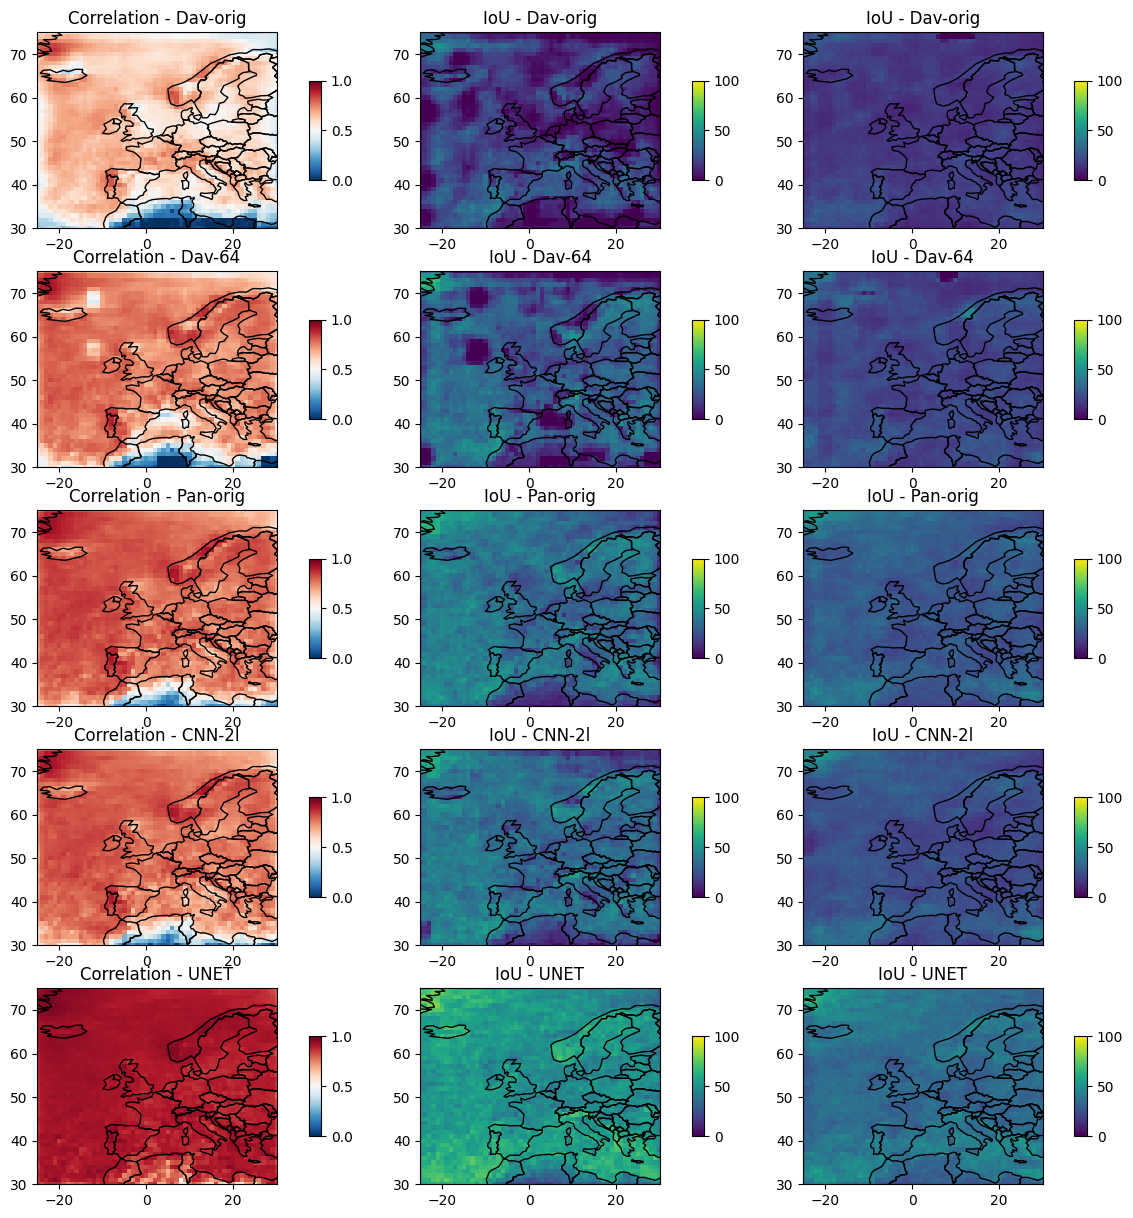

In [42]:
xr_true = convert_to_xarray(dg_test_Y, lats_y, lons_x, times)

n_rows = len(models_report)
fig, axs = plt.subplots(n_rows, 3, figsize=(14, n_rows*3))

for idx, m_id in enumerate(models_report):
    print(m_id)
    pred_test = np.load(f'tmp/data/predictions/y_pred_test_{m_id}.npy')
    # for extremes
    #pred_train_xtrm = np.load(f'tmp/data/predictions/y_pred_train_xtrm_{m}.npy')
    pred_test_xtrm = np.load(f'tmp/data/predictions/y_pred_test_xtrm_{m_id}.npy')
    
    y_pred_bool = pred_test > qq
    # Multiply to transform to numeric values
    y_pred_bool = y_pred_bool * 1
    # for the correlation
    xr_pred = convert_to_xarray(pred_test, lats_y, lons_x, times)
    
    cc = xr.apply_ufunc(
        get_corrcoef,    # First the function
        xr_true, xr_pred,        # then the input data arrays
        input_core_dims=[['time'], ['time']],
        vectorize=True)

    test_iou=IoU(dg_test_Y_xtrm, y_pred_bool)
    prec_xtrm = np.where(pred_test_xtrm > 0.5, 1, 0)
    test_iou_xtrm=IoU(dg_test_Y_xtrm, prec_xtrm)
    
    # Plotting for each DNN-as Fig.1
    
    plot_map(axs[idx,0], lons_x, lats_y, cc, vmin = 0, vmax = 1, cmap = "RdBu_r", title=f"Correlation - {m_id}")
    plot_map(axs[idx,1], lons_x, lats_y, test_iou, vmin = 0, vmax = 100, title=f"IoU - {m_id}")
    plot_map(axs[idx,2], lons_x, lats_y, test_iou_xtrm, vmin = 0, vmax = 100, title=f"IoU - {m_id}")